In [1]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set f

In [2]:
_d = np.load('../data/data_clean2_128_train.npz')
X = _d['X']
Y = _d['Y']
X_pids = _d['pids']

# Turn labels into boolean present/missing
Y_binary = np.sum(np.sum(Y, axis=2), axis=1) > 0
Y_binary = Y_binary.astype(np.float32)

In [3]:
# Also load the non-filtered data for evaluation
_d = np.load('../data/data_128_train.npz')
X_full = _d['X'][:,None,:,:]
Y_full = _d['Y'][:,None,:,:]

In [4]:
print X.shape
print Y.shape
print X.dtype
print Y.dtype

(5635, 128, 128)
(5635, 128, 128)
float32
float32


In [5]:
if False:
    # Split patients in train/test
    train_pids, test_pids = train_test_split(np.unique(X_pids), test_size=0.2)
    print train_pids
    print test_pids
    
    train_indices = np.flatnonzero(np.in1d(X_pids, train_pids))
    test_indices = np.flatnonzero(np.in1d(X_pids, test_pids))
    X_train = X[train_indices][:,None,:,:]
    Y_train_binary = Y_binary[train_indices][:,None]
    Y_train = Y[train_indices][:,None,:,:]
    X_test = X[test_indices][:,None,:,:]
    Y_test_binary = Y_binary[test_indices][:,None]
    Y_test = Y[test_indices][:,None,:,:]
else:
    nsamples = X.shape[0]

    #train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.1)
    train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.2)
    X_train = X[train_indices][:,None,:,:]
    Y_train_binary = Y_binary[train_indices][:,None]
    Y_train = Y[train_indices][:,None,:,:]
    X_test = X[test_indices][:,None,:,:]
    Y_test_binary = Y_binary[test_indices][:,None]
    Y_test = Y[test_indices][:,None,:,:]

In [6]:
import skimage.transform as sktransf

def rand_float(rng):
    return rng[0] + np.random.random() * (rng[1] - rng[0])

def generate_image(X_img, Y_img, angle_range=None, zoom_range=None, shear_range=None, horiz_shift_range=None,
                   vert_shift_range=None):
    """
    Randomly shift an image by resizing and then random croping
    the resized image
    """
    if angle_range is None:
        angle_range = (-5, 5)
    if zoom_range is None:
        zoom_range = (0.8, 1.2)
    if shear_range is None:
        shear_range = (-5, 5) # shear angle in degrees
    if horiz_shift_range is None:
        horiz_shift_range = (-5, 5)
    if vert_shift_range is None:
        vert_shift_range = (-5, 5)
    inshape = X_img.shape
    
    X2 = X_img.copy()
    Y2 = Y_img.copy()
    
    # -- random rotation
    angle = np.deg2rad(rand_float(angle_range))
    zoom = rand_float(zoom_range)
    shear = np.deg2rad(rand_float(shear_range))
    horiz_shift = rand_float(horiz_shift_range)
    vert_shift = rand_float(vert_shift_range)
    
    tform = sktransf.AffineTransform(
        scale=(zoom, zoom),
        rotation=angle,
        shear=shear,
        translation=(horiz_shift, vert_shift)
    )
    X2 = sktransf.warp(X2, tform, order=5, mode='edge')
    Y2 = sktransf.warp(Y2, tform, order=1)

    # gaussian noise
    #noise_scale = rand_float((0, 0.1))
    #X2 += np.random.normal(scale=noise_scale, size=X2.shape)
    Y2 = Y2 > 0.5
    return X2[None,:,:].astype(np.float32), Y2[None,:,:].astype(np.float32)

X_train_augmented = []
Y_train_augmented = []
for i in range(X_train.shape[0]):
    if i % 10 == 0:
        print '\r%d / %d' % (i, X_train.shape[0]),
        sys.stdout.flush()
    X_train_augmented.append(X_train[i])
    Y_train_augmented.append(Y_train[i])
    for j in range(2):
        X2, Y2 = generate_image(X_train[i].squeeze(), Y_train[i].squeeze())
        X_train_augmented.append(X2)
        Y_train_augmented.append(Y2)

4500 / 4508


In [7]:
X_train = np.array(X_train_augmented, dtype=np.float32)
Y_train = np.array(Y_train_augmented, dtype=np.float32)

Y_train_binary = np.sum(np.sum(Y_train.squeeze(), axis=2), axis=1) > 0
Y_train_binary = Y_train_binary.astype(np.float32)
Y_train_binary = Y_train_binary[:,None]

In [8]:
print X_train.shape
print Y_train.shape
print X_test.shape
print X_train.min(), X_train.max()

(13524, 1, 128, 128)
(13524, 1, 128, 128)
(1127, 1, 128, 128)
0.0 1.0


In [16]:
import cv2
def _resize(Y, outshape):
    return cv2.resize(Y.squeeze(), outshape, interpolation=cv2.INTER_AREA)[None, :, :]
Y_train_88 = np.array([_resize(img, (8, 8)) for img in Y_train])
Y_test_88 = np.array([_resize(img, (8, 8)) for img in Y_test])
Y_train_44 = np.array([_resize(img, (4, 4)) for img in Y_train])
Y_test_44 = np.array([_resize(img, (4, 4)) for img in Y_test])

In [17]:
with_bp = np.flatnonzero(np.sum(np.sum(np.sum(Y_train, axis=1), axis=1), axis=1))

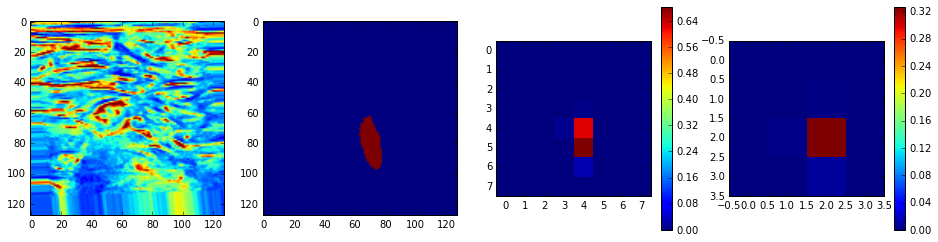

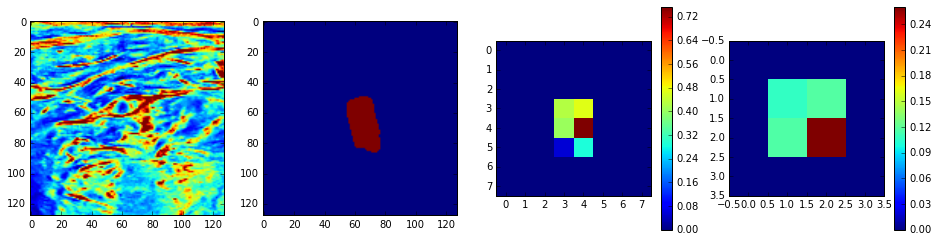

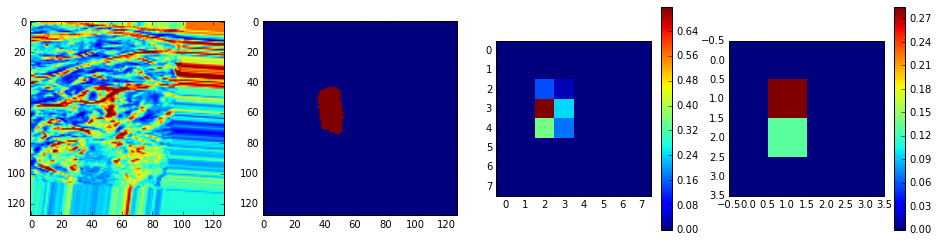

In [18]:
for bpi in range(11, 14):
    i = with_bp[bpi]
    pl.figure(figsize=(16, 4))
    pl.subplot(141)
    pl.imshow(X_train[i].squeeze())
    pl.subplot(142)
    pl.imshow(Y_train[i].squeeze())
    pl.subplot(143)
    pl.imshow(Y_train_88[i].squeeze(), interpolation='nearest')
    pl.colorbar()
    pl.subplot(144)
    pl.imshow(Y_train_44[i].squeeze(), interpolation='nearest')
    pl.colorbar()

# Keras model

In [19]:
# channels first in keras
input_shape = X_train[0].shape
print input_shape

(1, 128, 128)


In [20]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, MaxoutDense
from keras.layers import LeakyReLU, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import keras.backend as K

In [21]:
import theano
print theano.config.device

gpu0


In [22]:
from keras.layers import Layer, InputSpec
import keras.initializations
import keras.backend as K

class Maxout2D(Layer):
    def __init__(self, output_dim, cardinality, init='glorot_uniform', **kwargs):
        super(Maxout2D, self).__init__(**kwargs)
        # the k of the maxout paper
        self.cardinality = cardinality
        # the m of the maxout paper
        self.output_dim = output_dim
        self.init = keras.initializations.get(init)
    
    def build(self, input_shape):
        self.input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_shape[1], input_shape[2], input_shape[3]))]
        self.W = self.init((self.input_dim, self.output_dim, self.cardinality),
                           name='{}_W'.format(self.name))
        self.b = K.zeros((self.output_dim, self.cardinality))
        self.trainable_weights = [self.W, self.b]
              
    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        # flatten the spatial dimensions
        flat_x = K.reshape(x, (-1, input_shape[1], input_shape[2] * input_shape[3]))
        output = K.dot(
            K.permute_dimensions(flat_x, (0, 2, 1)),
            K.permute_dimensions(self.W, (1, 0, 2))
        )
        output += K.reshape(self.b, (1, 1, self.output_dim, self.cardinality))
        output = K.max(output, axis=3)
        output = output.transpose(0, 2, 1)
        output = K.reshape(output, (-1, self.output_dim, input_shape[2], input_shape[3]))
        return output
    
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.output_dim, input_shape[2], input_shape[3])
    
    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'cardinality': self.cardinality
        }
        base_config = super(Maxout2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [23]:
input_img = x = Input(shape=input_shape, name='input_img')
x = Dropout(0.25)(x)
x = Convolution2D(32, 3, 3, border_mode='same')(input_img)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
pool1 = x = MaxPooling2D((2, 2), name='pool1')(x)

x = Dropout(0.25)(x)
x = Convolution2D(32, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
pool2 = x = MaxPooling2D((2, 2), name='pool2')(x)

x = Dropout(0.25)(x)
x = Convolution2D(32, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
pool3 = x = MaxPooling2D((2, 2), name='pool3')(x)

# -- binary presence part
x = Dropout(0.25)(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
pool4 = x = MaxPooling2D((2, 2), name='pool4')(x)

x = Dropout(0.25)(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
pool5 = x = MaxPooling2D((2, 2), name='pool5')(x)

# Since some images have not mask, the hope is that the innermost units capture this
x = Flatten()(pool5)
x = Dense(32)(x)
x = LeakyReLU()(x)
x = Dense(16)(x)
x = LeakyReLU()(x)
outbin = Dense(1, activation='sigmoid', name='outbin')(x)

# turn pool4 and 5 into classification map
outmap4 = Convolution2D(1, 3, 3, border_mode='same', activation='sigmoid', name='outmap4')(pool4)

outmap5 = Convolution2D(1, 3, 3, border_mode='same', activation='sigmoid', name='outmap5')(pool5)

# upsample the classif map
x = merge([
        UpSampling2D((2, 2))(outmap4),
        UpSampling2D((4, 4))(outmap5),
        pool3
    ], mode='concat', concat_axis=1)
x = Convolution2D(16, 3, 3, border_mode='same')(pool3)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool2], mode='concat', concat_axis=1)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool1], mode='concat', concat_axis=1)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Maxout2D(16, 2)(x)
x = UpSampling2D((2, 2))(x)

x = Dropout(0.25)(x)
x = Convolution2D(8, 3, 3, border_mode='same')(x)
x = Convolution2D(8, 3, 3, border_mode='same')(x)
outmap = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same', name='outmap')(x)

model = Model(
    input=input_img,
    output=[outmap, outmap4, outmap5, outbin]
)

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='binary_crossentropy')
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
#model.compile(optimizer=rmsprop, loss='binary_crossentropy')
metrics={'outbin': 'accuracy'}
model.compile(optimizer='adam', loss='binary_crossentropy',
              loss_weights=[1., 0.2, 0.05, 0.01], metrics=metrics)

print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_img (InputLayer)             (None, 1, 128, 128) 0                                            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)    (None, 32, 128, 128)320         input_img[0][0]                  
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)    (None, 16, 128, 128)4624        convolution2d_3[0][0]            
____________________________________________________________________________________________________
maxout2d_1 (Maxout2D)              (None, 16, 128, 128)544         convolution2d_4[0][0]            
___________________________________________________________________________________________

In [24]:
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

#from keras.utils.visualize_util import plot
#plot(model, to_file='model.png')

Train on 13524 samples, validate on 1127 samples
Epoch 1/60
13524/13524 [==============================] - 165s - loss: 0.1129 - outmap_loss: 0.0759 - outmap4_loss: 0.1167 - outmap5_loss: 0.1332 - outbin_loss: 0.7001 - outbin_acc: 0.5666 - val_loss: 0.0758 - val_outmap_loss: 0.0457 - val_outmap4_loss: 0.0941 - val_outmap5_loss: 0.0963 - val_outbin_loss: 0.6475 - val_outbin_acc: 0.6264
Epoch 2/60
13524/13524 [==============================] - 166s - loss: 0.0682 - outmap_loss: 0.0460 - outmap4_loss: 0.0605 - outmap5_loss: 0.0762 - outbin_loss: 0.6276 - outbin_acc: 0.6502 - val_loss: 0.0595 - val_outmap_loss: 0.0378 - val_outmap4_loss: 0.0566 - val_outmap5_loss: 0.0820 - val_outbin_loss: 0.6246 - val_outbin_acc: 0.6655
Epoch 3/60
13524/13524 [==============================] - 166s - loss: 0.0614 - outmap_loss: 0.0410 - outmap4_loss: 0.0552 - outmap5_loss: 0.0692 - outbin_loss: 0.5976 - outbin_acc: 0.6864 - val_loss: 0.0597 - val_outmap_loss: 0.0375 - val_outmap4_loss: 0.0637 - val_outmap

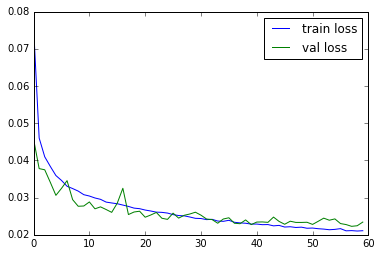

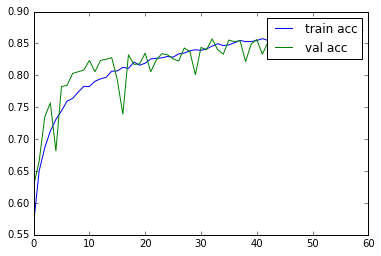

In [25]:
if True:
    json_string = model.to_json()
    open('architecture.json', 'w').write(json_string)
    
    model_checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True, verbose=True)
    
    history = model.fit(
        X_train,
        {
            'outmap': Y_train,
            'outmap4' : Y_train_88,
            'outmap5' : Y_train_44,
            'outbin': Y_train_binary
        },
        batch_size=64,
        validation_data=(X_test, {
                'outmap': Y_test,
                'outmap4' : Y_test_88,
                'outmap5' : Y_test_44,
                'outbin': Y_test_binary
        }),
        nb_epoch=60,# 40 + 10 + 10 + 5 + 5
        verbose=1,
        shuffle=True,
        callbacks=[model_checkpoint]
    )
    
    pl.figure()
    pl.plot(history.history['outmap_loss'], label='train loss')
    pl.plot(history.history['val_outmap_loss'], c='g', label='val loss')
    pl.legend()

    pl.figure()
    pl.plot(history.history['outbin_acc'], label='train acc')
    pl.plot(history.history['val_outbin_acc'], c='g', label='val acc')
    pl.legend()
else:
    model_dir = '.'
    model = model_from_json(
        open(os.path.join(model_dir, 'architecture.json')).read(),
                custom_objects={'Maxout2D' : Maxout2D}
    )
    model.load_weights(os.path.join(model_dir, 'weights.hdf5'))
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  loss_weights=[1., 0.01])
    
    print_summary(model.layers)

In [26]:
if False:
    model_dir = '.'
    json_string = model.to_json()
    open(os.path.join(model_dir, 'architecture_final.json'), 'w').write(json_string)
    model.save_weights(os.path.join(model_dir, 'weights_final.hdf5'))

Best map_thresh=0.400000, bin_thresh=0.750000


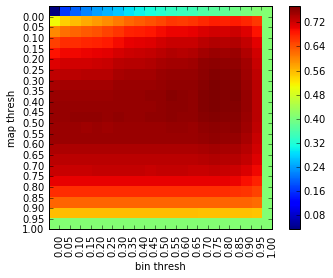

In [27]:
def compute_scores_map(X, Y):
    Y_pred, Y_pred_88, Y_pred_44, Y_pred_binary = model.predict(X)
    
    map_threshs = np.linspace(0, 1, num=21)
    bin_threshs = np.linspace(0, 1, num=21)
    
    scores = np.zeros((len(map_threshs), len(bin_threshs)))
    for i in range(len(map_threshs)):
        for j in range(len(bin_threshs)):
            _Y_pred = Y_pred > map_threshs[i]
            
            for k in range(_Y_pred.shape[0]):
                # Clear prediction where we detect to little pixels
                if np.sum(_Y_pred[k]) < 150 or Y_pred_binary[k] < bin_threshs[j]:
                    _Y_pred[k,:] = 0
            
            scores[i, j] = utils.average_dice_coefficient(_Y_pred, Y)
    
    pl.imshow(scores, interpolation='nearest')
    pl.yticks(np.arange(len(map_threshs)) + 0.5, ['%.2f' % v for v in map_threshs])
    pl.xticks(np.arange(len(bin_threshs)) + 0.5, ['%.2f' % v for v in bin_threshs], rotation=90)
    pl.ylabel('map thresh')
    pl.xlabel('bin thresh')
    pl.colorbar()
    
    best_i, best_j = np.unravel_index(np.argmax(scores.ravel()), scores.shape)
    best_map_thresh = map_threshs[best_i]
    best_bin_thresh = bin_threshs[best_j]
    return best_map_thresh, best_bin_thresh

map_thresh, bin_thresh = compute_scores_map(X_test, Y_test)
print 'Best map_thresh=%f, bin_thresh=%f' % (map_thresh, bin_thresh)

In [28]:
#map_thresh = 0.45
#bin_thresh = 0.9

In [29]:
def predict(X, map_thresh, bin_thresh):
    Y_pred, Y_pred_88, Y_pred_44, Y_pred_binary = model.predict(X)
    Y_pred_binary = Y_pred_binary.squeeze()
    Y_pred_proba = Y_pred
    Y_pred = Y_pred > map_thresh
    for i in range(Y_pred.shape[0]):
        if np.sum(Y_pred[i]) < 150 or Y_pred_binary[i] < bin_thresh:
            Y_pred[i,:] = 0
        pass
    return Y_pred, Y_pred_proba, Y_pred_binary

Y_pred, Y_pred_proba, Y_pred_binary = predict(X_test, map_thresh, bin_thresh)
Y_full_pred, Y_full_pred_proba, Y_full_pred_binary = predict(X_full, map_thresh, bin_thresh)

print "test set score : ", utils.dice_coefficient(Y_pred, Y_test)
print "avg test set score : ", utils.average_dice_coefficient(Y_pred, Y_test)
print "full set score : ", utils.dice_coefficient(Y_full_pred, Y_full)
print "avg full set score : ", utils.average_dice_coefficient(Y_full_pred, Y_full)

test set score :  0.725374103461
avg test set score :  0.773611528534
full set score :  0.641008740507
avg full set score :  0.704318207556


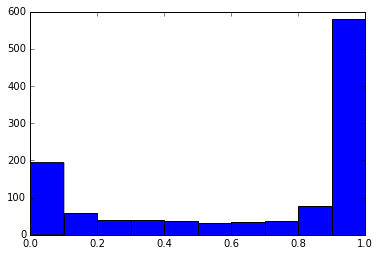

In [30]:
_ = pl.hist(Y_pred_binary)

In [31]:
# Find the images with lowest scores
dice_scores = []
for i in range(Y_pred.shape[0]):
    dice_scores.append(utils.dice_coefficient(Y_pred[i], Y_test[i]))
dice_scores = np.array(dice_scores)
lowest = np.argsort(dice_scores)

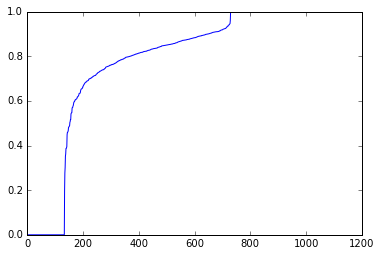

In [32]:
pl.plot(dice_scores[lowest])
#pl.plot(Y_pred_binary[lowest], c='r')

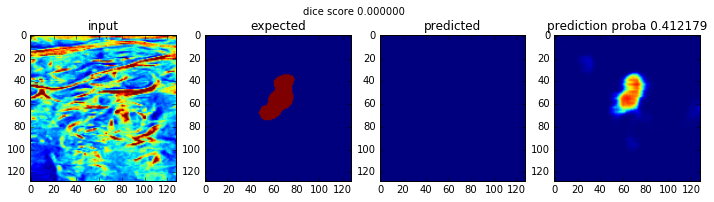

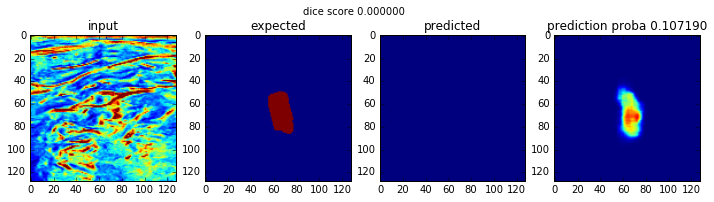

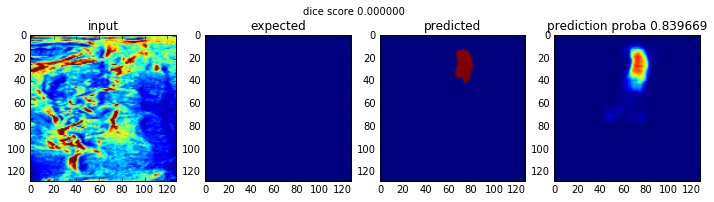

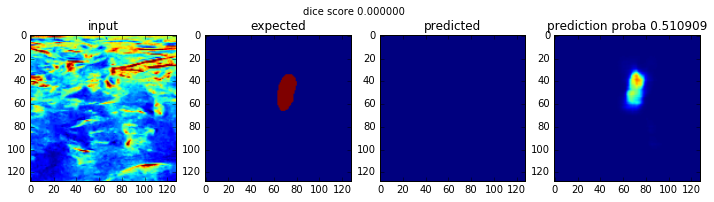

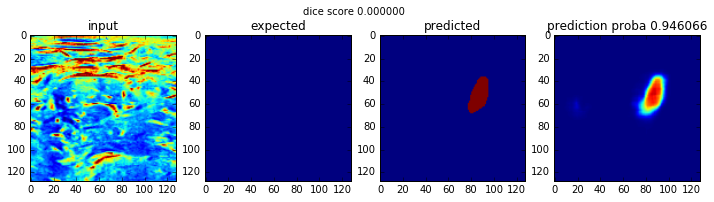

In [33]:
#i = 50
#i = 47

#for i in lowest[380:385]:
for i in lowest[50:55]:
    pl.figure(figsize=(12, 3))
    pl.suptitle('dice score %f' % utils.dice_coefficient(Y_pred[i], Y_test[i]))
    pl.subplot(141)
    pl.title('input')
    pl.imshow(X_test[i].squeeze())
    pl.subplot(142)
    pl.title('expected')
    pl.imshow(Y_test[i].squeeze())
    pl.subplot(143)
    pl.title('predicted')
    pl.imshow(Y_pred[i].squeeze(), vmin=0, vmax=1)
    pl.subplot(144)
    #print np.sum(Y_pred[i].squeeze())
    pl.title('prediction proba %f' % Y_pred_binary[i])
    pl.imshow(Y_pred_proba[i].squeeze(), vmin=0, vmax=1)

# Filters visualization

In [34]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [35]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [36]:
import keras.backend as K

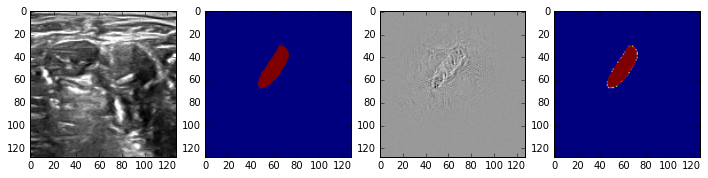

In [37]:
# Dream for the classifmap output
def dream_output(output):
    layer_output = layer_dict['outmap'].output
    # minimize difference between requested output and actual
    loss = K.mean(K.square(output[None,:,:,:] - layer_output))

    # compute the gradient of the input picture wrt this loss
    input_img = layer_dict['input_img'].input
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, input_shape[0], input_shape[1], input_shape[2])) * 0.2 + 0.5
    input_img_data = input_img_data.astype(np.float32)

    orig_img = input_img_data.copy()
    
    step = 0.1
    for i in range(30):
        # 0 is to disable training_phase
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data -= grads_value * step
        
        # normalize to 0-1
        #input_img_data = (input_img_data - input_img_data.min()) / (input_img_data.max() - input_img_data.min())

    img = input_img_data[0].squeeze()
    # run the image through the model to get prediction
    pred_map, pred44, pred88, binary_pred = model.predict(img[None,None,:,:])
    return img, pred_map

i = 15
img, pred_map = dream_output(Y_full[i])
pl.figure(figsize=(12, 4))
pl.subplot(141)
pl.imshow(X_full[i].squeeze(), cmap=cm.gray)
pl.subplot(142)
pl.imshow(Y_full[i].squeeze())
pl.subplot(143)
pl.imshow(img, cmap=cm.gray)
pl.subplot(144)
pl.imshow(pred_map.squeeze())

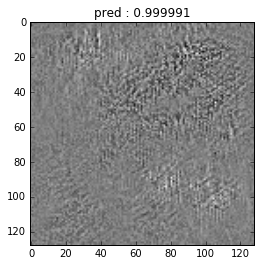

In [38]:
# Dream for the binary output
def dream_binoutput(output):
    
    layer_output = layer_dict['outbin'].output
    # minimize difference between requested output and actual
    loss = K.mean(K.square(output - layer_output[:, 0]))
    
    input_img = layer_dict['input_img'].input

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, input_shape[0], input_shape[1], input_shape[2])) * 0.2
    input_img_data = input_img_data.astype(np.float32)

    orig_img = input_img_data.copy()

    
    step = 0.1
    for i in range(40):
        # 0 is to disable training_phase
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data -= grads_value * step
        
        # normalize to 0-1
        #input_img_data = (input_img_data - input_img_data.min()) / (input_img_data.max() - input_img_data.min())

    img = input_img_data[0].squeeze()
    # run the image through the model to get prediction
    _, _, _, model_pred = model.predict(img[None,None,:,:])
    return img, model_pred

img, model_pred = dream_binoutput(1)
pl.title('pred : %f' % model_pred)
pl.imshow(img, cmap=cm.gray)

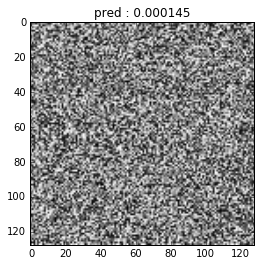

In [40]:
img, model_pred = dream_binoutput(0)
pl.title('pred : %f' % model_pred)
pl.imshow(img, cmap=cm.gray)

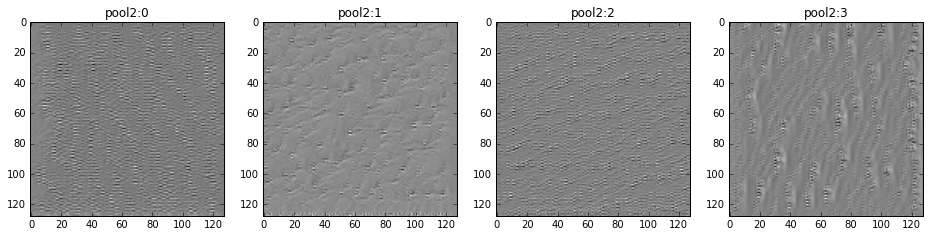

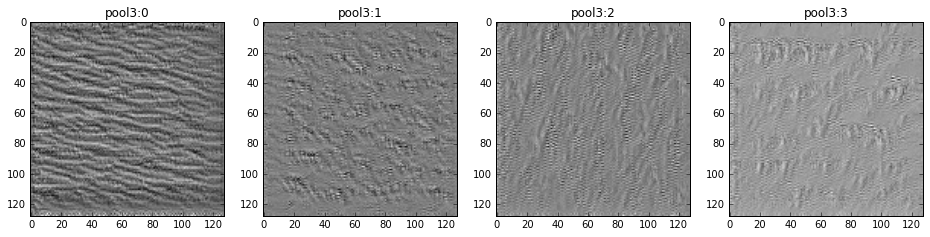

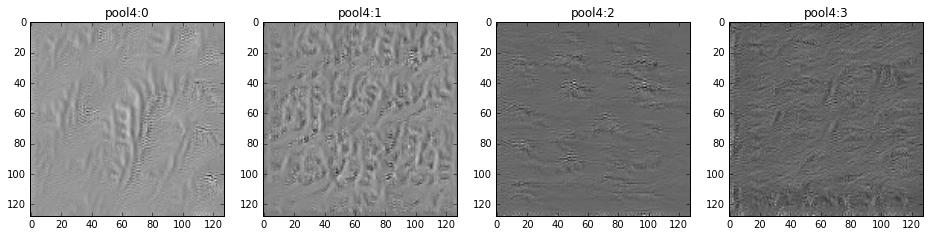

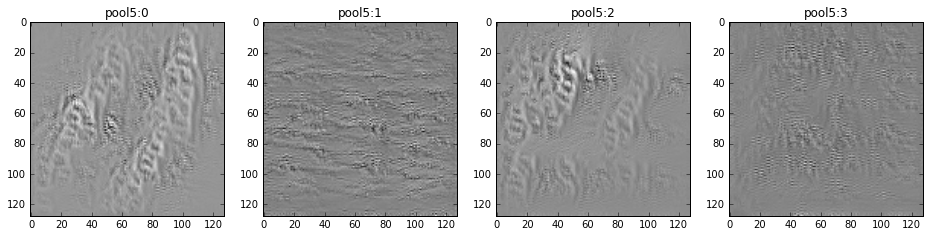

In [41]:
def dream_layer_filter(layer_name, filter_index):
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, filter_index, :, :])
    
    input_img = layer_dict['input_img'].input

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, input_shape[0], input_shape[1], input_shape[2])) * 0.2 + 0.5
    input_img_data = input_img_data.astype(np.float32)

    orig_img = input_img_data.copy()

    # run gradient ascent for 20 steps
    step = 0.1
    for i in range(20):
        # 0 is to disable training_phase
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data += grads_value * step

        # normalize to 0-1
        #input_img_data = (input_img_data - input_img_data.min()) / (input_img_data.max() - input_img_data.min())

    img = input_img_data[0].squeeze()
    return img
    #img = deprocess_image(img)
    
    
for layer_name in ['pool2', 'pool3', 'pool4', 'pool5']:
    pl.figure(figsize=(16, 8))
    for i in range(4):
        pl.subplot(1, 4, i + 1)
        pl.title('%s:%d' % (layer_name, i))
        img = dream_layer_filter(layer_name, i)
        pl.imshow(img, cmap=cm.gray)

# Run the model on kaggle'7 test set

In [39]:
_d = np.load('../data/data_128_test.npz')
X_submit = _d['X']

for m_t, b_t in [(0.3, 0), (0.5, 0), (0.5, 0.5), (0.5, 0.8)]:
    _pred, _pred_proba, _pred_binary = predict(X_submit[:,None,:,:], m_t, b_t)
    # Turn labels into boolean present/missing
    _pred_binary = np.sum(np.sum(np.sum(_pred, axis=2), axis=1), axis=1) > 0
    _pred_binary = _pred_binary.astype(np.float32)
    per_mask = (100 * np.count_nonzero(_pred_binary) / float(len(_pred_binary)))
    print 'map_thresh=%f, bin_thresh=%f => %.2f%% with masks' % (m_t, b_t, per_mask)

map_thresh=0.300000, bin_thresh=0.000000 => 64.05% with masks
map_thresh=0.500000, bin_thresh=0.000000 => 52.81% with masks
map_thresh=0.500000, bin_thresh=0.500000 => 50.20% with masks
map_thresh=0.500000, bin_thresh=0.800000 => 42.97% with masks


In [40]:
map_thresh = 0.5
bin_thresh = 0.8

In [41]:
if True:
    import cv2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))
    
    _d = np.load('../data/data_128_test.npz')
    X_submit = _d['X']
    test_fnames = _d['test_fnames']
    # bin_thresh
    Y_pred, Y_pred_proba, Y_pred_binary = predict(X_submit[:,None,:,:],
                                                  map_thresh, bin_thresh)
    
    OUTDIR='../../preds'
    if os.path.exists(OUTDIR):
        shutil.rmtree(OUTDIR)
    utils.mkdir_p(OUTDIR)

    for i in range(Y_pred.shape[0]):
        imre = cv2.resize((Y_pred[i].squeeze() * 255).astype(np.uint8), (580, 420))
        #imre = cv2.morphologyEx(imre, cv2.MORPH_CLOSE, kernel)
        basename = os.path.splitext(test_fnames[i])[0]
        cv2.imwrite(os.path.join(OUTDIR, basename + '.png'), imre)
        
        if i % 10 == 0:
            print '\r%d / %d' % (i, len(test_fnames)),
            sys.stdout.flush()

5500 / 5508


## Stats on predicted masks

(0, 1200)

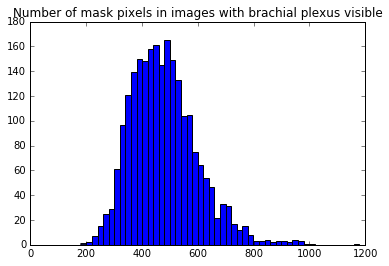

In [42]:
# on Y_full
nbp_pixels = np.sum(np.sum(np.sum(Y_full, axis=1), axis=1), axis=1)
bpvisible = nbp_pixels > 0

pl.figure()
pl.title('Number of mask pixels in images with brachial plexus visible')
_ = pl.hist(nbp_pixels[bpvisible], bins=50)
pl.xlim((0, 1200))

(0, 1200)

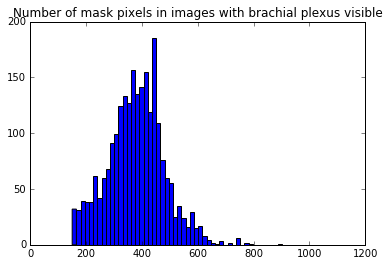

In [43]:
# on pred
nbp_pixels = np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1)
bpvisible = nbp_pixels > 0

pl.figure()
pl.title('Number of mask pixels in images with brachial plexus visible')
_ = pl.hist(nbp_pixels[bpvisible], bins=50)
pl.xlim((0, 1200))